# Application of machine learning concepts on lung X-rays to indicate COVID-19

In this project we will build and train a neural network in Tensorflow. 
- more details
- Dataset: [Public X-rays on Github](https://github.com/ieee8023/covid-chestxray-dataset)
- Waterkant Dataset: [CAU cloud as zip](https://cloud.physik.uni-kiel.de/index.php/s/aLDok2nyDawrHnE)





#TO DO LIST
- Preprocess the images: Make them all purely grayscale (and mark them for potential problems) <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Brightness augmentations <font color="green"> $\boxed{\checkmark}$ VD </font>
- Noise/Interference augmentations
- In-Process plots to monitor the learning and source data plots <font color="green"> $\boxed{\checkmark}$ VD </font>
- Data evaluation plots to spot possible overfitting or other issues <font color="green"> $\boxed{\checkmark}$ VD </font>
- Including a git-pull instead of resetting every time <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Create automatic steps per epoch integer<font color="green"> $\boxed{\checkmark}$ VD </font>
- Add confusion matrix
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add upload field for testing unclassified images from extern
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add imread from 2 class source for KFStratified
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add model.evaluation
- Add regular expressions to data management, to anticipate slightly misslabeled entries
- Include a pre-trained neural network VGG16, see http://www.robots.ox.ac.uk/~vgg/research/very_deep/<font color="green"> $\boxed{\checkmark}$ VD </font>
- Include more pre-trained NNs as alternative, e.g. ResNet50 from Keras https://engmrk.com/kerasapplication-pre-trained-model/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Additional Ideas

## General settings

In [113]:
#Clean and download the data
download_data=False
running_on_colab=False
copy_input_to_output=False
n_dense_plus_dropout_layers=2

## Imports

In [105]:
#Basics
import os
import random
import shutil
import re
import numpy as np
import cv2
from tqdm import tqdm
from shutil import copyfile
from os import getcwd
import pandas as pd
import zipfile
import json
import math
from datetime import datetime

#Neural Network related
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

# Required to save tf.keras models in HDF5 format
#!pip install -q pyyaml h5py

#Pretrained Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model

#Displaying
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

#KF
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
#from google.colab import files
from keras.preprocessing import image


2.2.0


In [106]:
def rmDir(d):
  try:
    shutil.rmtree(d)
    print("Directory '%s' was successfully removed." %d)
  except OSError as error:
    print("Direcotry '%s' does not exist." %d)

def rmSeveralDirs(dlist):
  for d in dlist:
    rmDir(d)

def createDir(d):
  try: 
    os.makedirs(d, exist_ok = True) 
    print("Directory '%s' was created successfully." %d) 
  except OSError as error: 
    print("Directory '%s' can not be created." %d)

def createSeveralDirs(dlist):
  for d in dlist:
    createDir(d)

def countFilesInDir(d):
  print(str(len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name))]))+" files in "+d)

## Data Handling

### Connecting to the Google Drive and setting the base_dir variable


In [107]:
if (running_on_colab):
    #Google
    from colab import drive
    cwd = '/content'
    gdrive_mount=os.path.join(cwd,'/gdrive')
    drive.mount(gdrive_mount)
    base_dir = os.path.join(gdrive_mount,'gdrive/My Drive/Xividocx-Data')
else:
    cwd = './'
    base_dir = os.path.join(cwd,'Xividocx-Data')

print("Project will be build in: "+os.path.abspath(base_dir))


Project will be build in: f:\Python\git-cloned\Xidivocx\Xividocx-Data


### Cleanup

In [108]:
if (download_data):
#Clean up directory
    rmDir(base_dir)
    createDir(base_dir)

### Downloading the first dataset containing training, testing and an unlabeled validation dataset (D10zip)

In [109]:
if (download_data):
    !curl -o D10.zip -L https://cloud.physik.uni-kiel.de/index.php/s/aLDok2nyDawrHnE/download
#Extract
    zip_ref = zipfile.ZipFile(os.path.join(cwd,'D10.zip'), 'r')
    zip_ref.extractall(base_dir)
    zip_ref.close()
    !rm $cwd/D10.zip

### Downloading the second dataset containing the additional validation dataset "MIX.zip"


In [110]:
if (download_data):
    !curl -o MIX.zip -L https://cloud.physik.uni-kiel.de/index.php/s/mAYD278NrifpkQo/download
#Extract
    zip_ref = zipfile.ZipFile(os.path.join(cwd,'MIX.zip'), 'r')
    zip_ref.extractall(os.path.join(base_inputdata_dir,'test2/MIX'))
    zip_ref.close()
    !rm $cwd/MIX.zip

### Defining input directories

In [208]:
#Set base input data dir accoridngly to
base_inputdata_dir = os.path.join(base_dir,'chest_xray')

#Also assign the archives subdirectorys to variables
waterkant20_train = base_inputdata_dir+'/train'

#training data in two groups
waterkant20_train_covid = waterkant20_train+'/PNEUMONIA'
waterkant20_train_nocovid = waterkant20_train+'/NORMAL'

waterkant20_val = base_inputdata_dir+'/val'

#validation data during training in two groups
waterkant20_val_covid = waterkant20_val+'/PNEUMONIA'
waterkant20_val_nocovid = waterkant20_val+'/NORMAL'


#first mixed test data not classified so far
waterkant20_test = base_inputdata_dir+'/test'
waterkant20_test_mix = waterkant20_test+'/MIX' # <=== Let's sort it!!!


In [209]:
#Also assign the archives subdirectorys to variables
waterkant20_test2  = base_inputdata_dir+'/test2'           #first mixed test data not classified so far
waterkant20_test2_mix = waterkant20_test2+'/MIX'           # <=== Let's sort it!!!

In [210]:
#Checking contents
waterkant20_path_list=[waterkant20_train_covid,waterkant20_val_covid,waterkant20_train_nocovid,waterkant20_val_nocovid,waterkant20_test_mix,waterkant20_test2_mix]

for path in waterkant20_path_list:
  countFilesInDir(path)

#3875 files in .../Xividocx-Data/chest_xray/train/PNEUMONIA
#8 files in .../Xividocx-Data/chest_xray/val/PNEUMONIA
#1341 files .../Xividocx-Data/chest_xray/train/NORMAL
#8 files in .../Xividocx-Data/chest_xray/val/NORMAL
#624 files in .../Xividocx-Data/chest_xray/test/MIX
#176 files in .../Xividocx-Data/chest_xray/test2/MIX

3875 files in ./Xividocx-Data\chest_xray/train/PNEUMONIA
8 files in ./Xividocx-Data\chest_xray/val/PNEUMONIA
1341 files in ./Xividocx-Data\chest_xray/train/NORMAL
8 files in ./Xividocx-Data\chest_xray/val/NORMAL
624 files in ./Xividocx-Data\chest_xray/test/MIX
176 files in ./Xividocx-Data\chest_xray/test2/MIX


### Defining output directories

In [211]:
#Base directory for monochromized files before feeding to Training/Testing and Prediction
base_outputdata_dir             = os.path.join(base_dir,'chest_xray_output')

training_dir         = os.path.join(base_outputdata_dir, 'training')
training_covid_dir   = os.path.join(training_dir, 'covid')
training_nocovid_dir = os.path.join(training_dir, 'nocovid')

testing_dir          = os.path.join(base_outputdata_dir, 'testing')
testing_covid_dir    = os.path.join(testing_dir, 'covid')
testing_nocovid_dir  = os.path.join(testing_dir, 'nocovid')

prediction_dir   = os.path.join(base_outputdata_dir, 'prediction') #First unlabeled datset for prediction
prediction2_dir = os.path.join(base_outputdata_dir, 'prediction2') #Second unlabeled datset for prediction

## Pre-Processing

### Monochromize and distribute data to the corresponding directories
The function monochromize(img) can monochromize (numpy)images. 
The function copyFileMonochromized uses monochromize() and in addition the output filename is expanded by keywords to reflect, if their input image:
*   did not have a dpi setting
*   did actually have color, expressed as with mean and max "color"-values

Some aspects could have been reflected by the .convert("L") function in tensorflow

In [212]:
#TD: monochromize the data! Using numpy slice operations: https://www.w3schools.com/python/numpy_array_slicing.asp
#TD: Using e ITU-R 601-2 luma transform: L = R * 299/1000 + G * 587/1000 + B * 114/1000, it does not affect already grayscale images saved as RGB...

#Reduces RGB and RGBA to monochrome numpy array
def monochromize(img): 
  if (img.ndim==2): 
    return img                                      #monochrome
  if (img.ndim==3):
    channels = img.shape[2]
    if (channels==3):
      return (img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114).astype(int) #RGB
    if (channels==4):
      return (img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114).astype(int) #RGBA - no usage of alpha channel
  print("image is neither of type monochrome,RGB or RGBA. Contact the dataset provider.")
  return img                                   


#TD: Apply monochromize while copying the file from path_in to path_out
def copyfileMonochromized(img_path_in,img_path_out):
  im = Image.open(img_path_in,mode="r")
  dpi = im.info.get('dpi')
  tags = []
  if dpi is None: #no dpi setting
    tags.append("nodpi")
  else:
    tags.append("dpi"+str(dpi))

    #check for color!
  img = np.asarray(im)
   
  if (img.ndim==3): #filled three channels, let's check for color now!
    if not (np.count_nonzero(img[:,:,0]-img[:,:,1])==0 and np.count_nonzero(img[:,:,0]-img[:,:,2])==0 and np.count_nonzero(img[:,:,1]-img[:,:,2])==0):
      maxi = np.amax([np.amax(np.abs(img[:,:,0].astype(int)-img[:,:,1])),np.amax(np.abs(img[:,:,0].astype(int)-img[:,:,2])),np.amax(np.abs(img[:,:,1].astype(int)-img[:,:,2]))])
      mean = (np.average(np.abs(img[:,:,0].astype(int)-img[:,:,1])) + np.average(np.abs(img[:,:,0].astype(int)-img[:,:,2])) + np.average(np.abs(img[:,:,1].astype(int)-img[:,:,2])))/3.0
      tags.append("color_max="+str(maxi))
      tags.append("color_mean="+str(mean))
    else:
      tags.append("nocolor")


  img = Image.open(img_path_in).convert('L')
  img.save(img_path_out)

  return tags
  
#    img = monochromize(img)
#    im2 = Image.fromarray(np.uint8(img))
#    dpi = im.info.get('dpi')
#    if dpi is None: #no dpi setting
#        im2.save(img_path_out+c+d+m+t)
#    else:
#      dpi_x,dpi_y = dpi
#      im2.save(img_path_out+c+m+t,resolution_unit="inch", x_resolution=dpi_x, y_resolution=dpi_y)

#TD: Apply monochromize to multiple file on a list of [src,dest] pairs
def copyfromSrcDirToDestDirMonochromized(src_dest_list):
  tagslist = []
  for src,dest in src_dest_list:
    tagslist.append([src])
    print("Copy "+src+" to "+dest)
    src_files = os.listdir(src)
    for file_name in src_files:
      full_file_src = os.path.join(src, file_name)
      full_file_dest = os.path.join(dest,file_name)
      if os.path.isfile(full_file_src):
        tagslist.append([file_name,copyfileMonochromized(full_file_src,full_file_dest)])
#Write logs from imageCheck to file
  file1 = open('./logs/image_readin_'+datetime.now().strftime('%Y%m%d%H%M%S')+'.log',"w")
  file1.writelines(["%s\n" % str(item)  for item in tagslist])
  file1.close()

### Copy first dataset into corresponding directories while monochromizing the data

In [213]:
#Delete and Create output dirs
dir_list = [training_covid_dir, training_nocovid_dir, testing_covid_dir, testing_nocovid_dir, prediction_dir]
if (copy_input_to_output):
  rmSeveralDirs(dir_list)
  createSeveralDirs(dir_list)

# Tuple list of directories with [source, destination] layout
waterkant20_src_dest_list=[[waterkant20_train_covid,training_covid_dir],
                           [waterkant20_val_covid,testing_covid_dir],
                           [waterkant20_train_nocovid,training_nocovid_dir],
                           [waterkant20_val_nocovid,testing_nocovid_dir],
                           [waterkant20_test_mix,prediction_dir]]

#TD Copy from src to dest
if (copy_input_to_output):
  copyfromSrcDirToDestDirMonochromized(waterkant20_src_dest_list)

#TD Check content in dest folder
for path in dir_list:
  countFilesInDir(path)

Directory './Xividocx-Data\chest_xray_output\training\covid' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\training\nocovid' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\testing\covid' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\testing\nocovid' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\prediction' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\training\covid' was created successfully.
Directory './Xividocx-Data\chest_xray_output\training\nocovid' was created successfully.
Directory './Xividocx-Data\chest_xray_output\testing\covid' was created successfully.
Directory './Xividocx-Data\chest_xray_output\testing\nocovid' was created successfully.
Directory './Xividocx-Data\chest_xray_output\prediction' was created successfully.
Copy ./Xividocx-Data\chest_xray/train/PNEUMONIA to ./Xividocx-Data\chest_xray_output\training\covid
Copy ./Xividocx-Data\chest_xray/va

### Copy second dataset into corresponding directories while monochromizing the data

In [214]:
#Delete and Create output dirs
dir_list2 = [prediction2_dir]
if (copy_input_to_output):
  rmSeveralDirs(dir_list2)
  createSeveralDirs(dir_list2)

# Tuple list of directories with [source, destination] layout
waterkant20_src_dest_list2=[[waterkant20_test2_mix,prediction2_dir]]

#TD Copy from src to dest
if (copy_input_to_output):
  copyfromSrcDirToDestDirMonochromized(waterkant20_src_dest_list2)

#TD Check content in dest folder
for path in dir_list2:
  countFilesInDir(path)

Directory './Xividocx-Data\chest_xray_output\prediction2' was successfully removed.
Directory './Xividocx-Data\chest_xray_output\prediction2' was created successfully.
Copy ./Xividocx-Data\chest_xray/test2/MIX to ./Xividocx-Data\chest_xray_output\prediction2
176 files in ./Xividocx-Data\chest_xray_output\prediction2


## Tensorflow Model setup

# Data Retrieval by ImageDataGenerator
- Setting up the ImageDataGenerators for training and testing
- in the training case with some augmentations
- set image size to 324 x 324 in the flow_from_directory method


In [215]:
tf.keras.backend.clear_session()

#Setting up the generators and creating and instance of it
#Hyperparameters
batch_size_training = 128 #TD without mirrored_strategy, aka on one GPU, I experiences a maximum of 64 here!!!
batch_size_testing = 16

#TD In case of multiple GPUs, batch_sizes are split, so each GPU (with mirrored parameters) will work on 1/n*batch_size. Parameter Update to all GPUs afteer each cycle through CPU.
#Currently, tf.distribute.HierarchicalCopyAllReduce and tf.distribute.ReductionToOneDevice are two options other than tf.distribute.NcclAllReduce which is the default.
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],cross_device_ops=tf.distribute.ReductionToOneDevice()) 

with mirrored_strategy.scope():

  training_datagen = ImageDataGenerator(rescale=1.0/255,
                                        rotation_range=10,
                                        zoom_range=0.1,
                                        brightness_range=[0.7,1.3],
                                        horizontal_flip=True,
                                        #vertical_flip=True,  #Not happening in our data
                                        fill_mode='nearest'
                                        )

  testing_datagen = ImageDataGenerator(rescale = 1.0/255.)

  training_generator = training_datagen.flow_from_directory(training_dir,
                                                            #color_mode="grayscale", #TD this is not possible without changing the input to the pre-trained net, so we create real grayscale jpegs above
                                                            batch_size=batch_size_training,
                                                            class_mode='binary',
                                                            target_size=(324, 324)
                                                            )

  testing_generator = testing_datagen.flow_from_directory(testing_dir,
                                                          #color_mode="grayscale", #TD this is not possible without changing the input to the pre-trained net, so we create real grayscale jpegs above
                                                          batch_size=batch_size_testing,
                                                          class_mode='binary',
                                                          target_size=(324, 324)
                                                          )

#Expected output training:   5216, 2 classes
#Expected output validation: 16,   2 classes 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Creating the Neural network 
- Based on pretrained model(VGG16)
- Exit at block3_pool layer of the VGG16 to keep a certain minimum shape to still work with
- A not untrained model can be found in the Appendix


In [216]:
with mirrored_strategy.scope():

#Create an instance of the pretrained model

#Setting up some Hyperparameters
  pre_trained_setup = "VGG16" #"ResNet50"  #Hyperparameter to change bewteen the pretrained models
  lr = 0.0003 # Learning rate # Adjusted by TD on 2020-06-16
  dr_0 = 0.05 # Dropout rate for first layer it appears in
  dr_1 = 0.05 # Dropout rate for second layer it appears in
  dr_2 = 0.05 # Dropout rate for third layer it appears in

  print("Model uses %s pairs of Dense and Dropout layers for training" % str(n_dense_plus_dropout_layers))

  if (pre_trained_setup == "VGG16"):
      print("Using VGG16")
      pre_trained_model = VGG16(input_shape = (324, 324, 3), 
                                include_top = False, 
                                weights = "imagenet"
                                ) # We can consider other weights too! VD see http://www.robots.ox.ac.uk/~vgg/research/very_deep/
  if (pre_trained_setup == "ResNet50"):
      print("Using ResNet50")
      pre_trained_model = ResNet50(input_shape = (324, 324, 3), 
                                   include_top = False, 
                                   weights = "imagenet"
                                   )

# Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
      layer.trainable = False
  
 # Print the model summary if you want further infos
 # print(pre_trained_model.summary())

#TD selectiong between VGG16 and ResNet50
#Choosing a "exit"-layer from the pretrained to further use the selfmodeled one
  if (pre_trained_setup == "VGG16"):
#last_layer = pre_trained_model.get_layer('block3_pool') # 40, 40, 256 =>  40, 40, 512
    last_layer = pre_trained_model.get_layer('block2_pool') # 80, 80
#last_layer = pre_trained_model.get_layer('block4_pool') # 40, 40
  if (pre_trained_setup == "ResNet50"):
    last_layer = pre_trained_model.get_layer('conv3_block2_add') # 41, 41, 512 => 41, 41, 512
  last_output = last_layer.output

# Add costum layers after the pretrained model for specific purposes
  output = layers.Conv2D(32, (3,3), activation='relu')(last_output)
  output = layers.AveragePooling2D(2,2)(output)
  output = layers.Conv2D(64, (3,3), activation='relu')(output)
  output = layers.MaxPooling2D(2,2)(output)
  output = layers.Dropout(dr_0)(output)
  output = layers.Conv2D(128, (3,3), activation='relu')(output)
  output = layers.MaxPooling2D(2,2)(output)
  output = layers.Flatten()(output) 
  if (n_dense_plus_dropout_layers>=1):
    output = layers.Dense(512, activation='relu')(output)
    output = layers.Dropout(dr_1)(output) 
  if (n_dense_plus_dropout_layers>=2):  
    output = layers.Dense(128, activation='relu')(output)
    output = layers.Dropout(dr_2)(output) 
  output = layers.Dense(1, activation='sigmoid')(output) 

# Create a instance of the model in the desired layout
  model = Model(pre_trained_model.input,output)   

#Compile it!
  model.compile(optimizer = Adam(learning_rate=lr), 
              loss = 'binary_crossentropy',
              metrics = ['acc']
              )

#Save initial weights, if you want to start over again below in the fit sections...
  model.save_weights('./initial_models/initial_model_weights.h5')

#Show the net
  model.summary()

Using VGG16
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 324, 324, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 324, 324, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 324, 324, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 162, 162, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 162, 162, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 162, 162, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 81, 81, 128) 

## Some usefull callbacks

In [217]:
with mirrored_strategy.scope():
  #Setup a Callback to not overcomputate
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = "acc", mode="max", verbose = 1)

  #Setup a Callback to save each epochs model, if it improved in training accuracy
  checkpoint_filepath = './checkpoints'
  createDir(checkpoint_filepath)
  model_save_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath+"/model-"+datetime.now().strftime('%Y%m%d%H%M%S')+"-{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5",
      save_weights_only=False, #model.save(filepath), if True model.save_weights(filepath)
      monitor='acc',
      mode='max',
      save_best_only=True
      )

#ToDo Learning Rate Finder
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
#              metrics=["mae"])
#history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Directory './checkpoints' was created successfully.


## Train the model on our training and testing data

There are three very similar methods to train a model:
<ol>
<li>fit_generator()</li>
<li>train_on_batch()</li>
<li>fit() <--- most flexible</li>
</ol>

### 0. Reset to initial weights to start a fresh training run

In [218]:
#model.load_weights('./initial_models/initial_model_weights.h5')

### 1. Using the fit_generator()


In [224]:
with mirrored_strategy.scope():

#Hyperparameter
  epochs = 100
  n_steps_per_epoch = int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training)
  n_validation_steps = int((len(os.listdir(testing_covid_dir))+len(os.listdir(testing_nocovid_dir)))/batch_size_testing)

  history = model.fit_generator(training_generator,
                              epochs=epochs,
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=testing_generator,
                              validation_steps=n_validation_steps,
                              callbacks=[model_save_callback,early_stopping_callback],
                              verbose = 1
                              )

Epoch 1/100
40/40 [==============================] - 192s 5s/step - loss: 0.0477 - acc: 0.9841 - val_loss: 0.7183 - val_acc: 0.6875
Epoch 2/100
40/40 [==============================] - 202s 5s/step - loss: 0.0447 - acc: 0.9823 - val_loss: 0.2916 - val_acc: 0.8750
Epoch 3/100
40/40 [==============================] - 313s 8s/step - loss: 0.0388 - acc: 0.9862 - val_loss: 0.0385 - val_acc: 1.0000
Epoch 4/100
40/40 [==============================] - 326s 8s/step - loss: 0.0375 - acc: 0.9862 - val_loss: 0.0218 - val_acc: 1.0000
Epoch 5/100
40/40 [==============================] - 266s 7s/step - loss: 0.0413 - acc: 0.9855 - val_loss: 0.0210 - val_acc: 1.0000
Epoch 6/100
40/40 [==============================] - 213s 5s/step - loss: 0.0444 - acc: 0.9833 - val_loss: 0.0518 - val_acc: 1.0000
Epoch 7/100
40/40 [==============================] - 206s 5s/step - loss: 0.0323 - acc: 0.9888 - val_loss: 0.0849 - val_acc: 0.9375
Epoch 8/100
40/40 [==============================] - 198s 5s/step - loss: 0.

### 2. Using train_on_batch()
train_on_batch allows you to expressly update weights based on a collection of samples you provide, without regard to any fixed batch size. You would use this in cases when that is what you want: to train on an explicit collection of samples

In [ ]:
#Hyperparameter
#epochs = 5

#n_steps_per_epoch = int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training)

#for j in range(20):
#    print('epoch: '+str(j)+' ----------------------------')
#    length = x_train.shape[0]
#    idxs = np.arange(0, length)
#    np.random.shuffle(idxs)
#    x_train = x_train[idxs]
#    y_train = y_train[idxs]
#    xb = np.array_split(x_train,n_steps_per_epoch)
#    yb = np.array_split(y_train,n_steps_per_epoch)
#    sumAcc = 0
#    index = list(range(386))
#    random.shuffle(index)
#    for i in index:
#        results = model.train_on_batch(xb[i],yb[i])
#        sumAcc += results[1]
#    print(sumAcc/(386))

### 3. Using fit()

In [89]:
with mirrored_strategy.scope():
#Hyperparameter
  epochs = 100
  n_steps_per_epoch = int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training)
  n_validation_steps = int((len(os.listdir(testing_covid_dir))+len(os.listdir(testing_nocovid_dir)))/batch_size_testing)

  history = model.fit(training_generator,
                    epochs=epochs,
                    steps_per_epoch=n_steps_per_epoch,
                    validation_data=testing_generator,
                    validation_steps=n_validation_steps,
                    callbacks=[model_save_callback,early_stopping_callback],
                    verbose=1
                    )

Epoch 1/100
40/40 [==============================] - 205s 5s/step - loss: 0.0357 - acc: 0.9860 - val_loss: 0.0478 - val_acc: 1.0000
Epoch 2/100
40/40 [==============================] - 196s 5s/step - loss: 0.0365 - acc: 0.9866 - val_loss: 0.0563 - val_acc: 1.0000
Epoch 3/100
40/40 [==============================] - 201s 5s/step - loss: 0.0273 - acc: 0.9894 - val_loss: 0.0126 - val_acc: 1.0000
Epoch 4/100
40/40 [==============================] - 193s 5s/step - loss: 0.0338 - acc: 0.9870 - val_loss: 0.0240 - val_acc: 1.0000
Epoch 5/100
40/40 [==============================] - 193s 5s/step - loss: 0.0307 - acc: 0.9880 - val_loss: 0.0676 - val_acc: 1.0000
Epoch 6/100
40/40 [==============================] - 193s 5s/step - loss: 0.0310 - acc: 0.9910 - val_loss: 0.0271 - val_acc: 1.0000
Epoch 7/100
40/40 [==============================] - 194s 5s/step - loss: 0.0240 - acc: 0.9925 - val_loss: 0.1002 - val_acc: 0.9375
Epoch 8/100
40/40 [==============================] - 214s 5s/step - loss: 0.

# Display Loss/Accuracy graphs to spot possible overfitting and estimated epochs for optimization

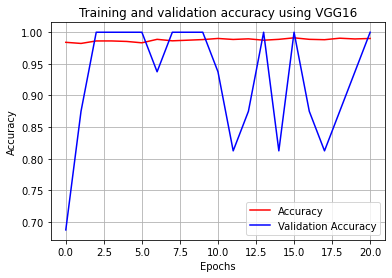

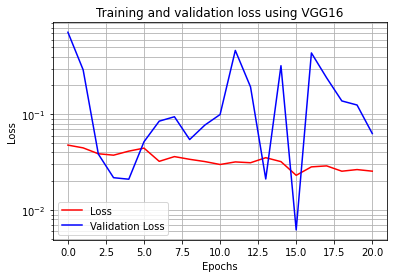

<Figure size 432x288 with 0 Axes>

In [225]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
def expand_history(history):
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs
    return epochs,acc,val_acc,loss,val_loss

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
def plot_acc(history):
    epochs,acc,val_acc,loss,val_loss = expand_history(history)
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy using '+pre_trained_setup)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(which='both', axis='both')
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
def plot_loss(history):
    epochs,acc,val_acc,loss,val_loss = expand_history(history)
    plt.yscale("log")
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss using '+pre_trained_setup)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(which='both', axis='both')
    plt.legend(["Loss", "Validation Loss"])
    plt.figure()

plot_acc(history)
plot_loss(history)

## Prediction and Result generation

### Just for the model in the current stage

In [15]:
#predictionOnDir = prediction_dir
predictionOnDir = prediction2_dir
waterkant_prediction_list = os.listdir(predictionOnDir)

nrlab = []
low=0;
hi=0;
for filename in waterkant_prediction_list:
  # predicting images
  path = predictionOnDir + '/' + filename
  img=image.load_img(path, target_size=(324, 324))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=100)
  nr = (re.match(r"^([^.]*)\..*$",filename)).group(1)
  lab = classes[0]
  c = int(round(lab[0]))
  nrlab.append([int(nr),c]) #TD sigmoid from -inf..inf spans 0..1, cut at 0.5
  if c == 1:
    hi += 1
  else:
    low +=1

print("Distribution: "+str(hi)+" High and "+str(low));

nrlab.sort(key=lambda tup: tup[0])

L = ["[\n"]  
for n,l in nrlab:
  L.append('  {"image": "'+str(n)+'.jpg", "prediction": '+str(l)+'},\n')
L[len(L)-1] = L[len(L)-1][:-2]+"\n"
L.append("]\n")
file1 = open('./output/covid-'+datetime.now().strftime('%Y%m%d%H%M%S')+'.json',"w")
file1.writelines(L)
file1.close()

Distribution: 0 High and 176


### For all model states saved to checkpoint_filepath

In [161]:
#predictionOnDir = prediction_dir
predictionOnDir = prediction2_dir
waterkant_prediction_list = os.listdir(predictionOnDir)

hdf5_model_list = os.listdir(checkpoint_filepath)

nrlabMatrix = []
jsonFileNames = []
for hdf5_model in hdf5_model_list:
  modelResurrect = tf.keras.models.load_model(checkpoint_filepath+"/"+hdf5_model)
  nrlab = []
  low=0
  hi=0
  for filename in waterkant_prediction_list:
    # predicting images
    path = prediction2_dir + '/' + filename
    img=image.load_img(path, target_size=(324, 324))
  
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    lab = modelResurrect.predict(np.vstack([x]),batch_size=1)[0]
    c = int(round(lab[0])) #TD sigmoid from -inf..inf spans 0..1, cut at 0.5
    nr = (re.match(r"^([^.]*)\..*$",filename)).group(1)
    nrlab.append([int(nr),c]) 
    if c == 1:
      hi += 1
    else:
      low +=1

  print("176 Test: "+str(hi)+" High and "+str(low)+" Low!");

  nrlab.sort(key=lambda tup: tup[0])
  nrlab = np.array(nrlab)

  L = ["[\n"]  
  for n,l in nrlab:
    L.append('  {"image": "'+str(n)+'.jpg", "prediction": '+str(l)+'},\n')
  L[len(L)-1] = L[len(L)-1][:-2]+"\n"
  L.append("]\n")
  jsonFileName = './output/covid-'+datetime.now().strftime('%Y%m%d%H%M%S')+hdf5_model+'.json'
  jsonFileNames.append(jsonFileName)
  file1 = open(jsonFileName,"w")
  file1.writelines(L)
  file1.close()

  jsonFileNames.append(jsonFileName)

  nrlabMatrix=np.column_stack((nrlabMatrix,nrlab[:,1]))



#Write logs from imageCheck to file
file1 = open('covid_overview_'+datetime.now().strftime('%Y%m%d%H%M%S')+'.log',"w")
file1.writelines(["%s\n" % str(labels) for labels in nrlabMatrix])
file1.write("___ModelFiles\n")
file1.writelines(["%s\n" % str(item) for item in hdf5_model_list])
file1.write("___ResultFiles\n")
file1.writelines(["%s\n" % str(item) for item in jsonFileNames])
file1.write("___ImageNames\n")
file1.writelines(["%s\n" % str(item) for item in waterkant_prediction_list])
file1.close()

176 Test: 66 High and 110 Low!
176 Test: 139 High and 37 Low!


# Main computation of the network with poor mans stratified folder system

### Base functions for further aritmetic procedures

In [226]:
# Find primes factors of a number n
def prime_factors(n):
    d = 2
    factors = []
    while n >= d*d:
        if n % d == 0:
            n//=d
            factors.append(d)
        else:
            d = d+1
    if n>1:
        factors.append(n)
    return factors

# Find the smallest available data subset from given list of directories and return its length
def minimum_length(dir_list):
    minimum = len(os.listdir(dir_list[0]))
    for directory in dir_list:
      if len(os.listdir(directory)) < minimum :
        minimum = len(os.listdir(directory))

    return minimum

# Function that suggests the amount of splits with given list of data directories
def split_suggest(dir_list):
    minimum = minimum_length(dir_list)
    prime_list = prime_factors(minimum)
    if len(prime_list) == 1:
      print("We suggest a split in", prime_list[0], "folders")
    else:
      #print("We suggest a split in either",prime_list[0],"," , prime_list[1], "or in", prime_list[0]*prime_list[1], "folders.")
      print("We suggest a split in any combination of the following numbers", prime_list)
    return     

### Get the split size via user input with system suggestion

In [231]:
#Suggest amount of splits
split_suggest(waterkant20_path_list)
#Get user feedback
split_number = int(input("Please make your choice: "))

if split_number > minimum_length(waterkant20_path_list):  #or split_number not in prime_factors(minimum_length(waterkant20_path_list)):
  print("Warning your choosen split number ", split_number ," is unacceptable, please reconsider!")
else:
  print("Acceptable choice")  

We suggest a split in any combination of the following numbers [2, 2, 2]
Acceptable choice


In [232]:
def dir_iterator (base_dir, split_number,variable_value):
  dir_set = {}
  for i in range(split_number):
    dir_set[variable_value + "_" + str(i)] = base_dir + "_" + str(i)

  locals().update(dir_set)
  dir_list = list(dir_set)
  return dir_list

def sub_dir_list (dir_list, sub_name):
  sub_list = []
  for entry in dir_list:
    temp_dir = os.path.join(entry, str(sub_name) )
    sub_list.append(temp_dir)
  return sub_list 

In [233]:
directories_training = dir_iterator(base_outputdata_dir,split_number,str(base_outputdata_dir)+'/training')
directories_testing = dir_iterator(base_outputdata_dir,split_number,str(base_outputdata_dir)+'/testing')

sub_directories_training_covid = sub_dir_list(directories_training, 'covid')
sub_directories_training_nocovid = sub_dir_list(directories_training, 'nocovid')
sub_directories_testing_covid = sub_dir_list(directories_testing, 'covid')
sub_directories_testing_nocovid = sub_dir_list(directories_testing, 'nocovid')


dir_list = []
dir_list.extend(sub_directories_training_covid)
dir_list.extend(sub_directories_training_nocovid)
dir_list.extend(sub_directories_testing_covid)
dir_list.extend(sub_directories_testing_nocovid)

#dir_list.extend(iteration_directories_testing_covid)
#dir_list.extend(iteration_directories_testing_nocovid)
#dir_list.extend(iteration_directories_training_covid)
#dir_list.extend(iteration_directories_training_nocovid)

for entry in dir_list:
    try: 
        os.makedirs(entry, exist_ok = True) 
        print("Directory '%s' was created successfully" %entry) 
    except OSError as error: 
        print("Directory '%s' can not be created" %entry) 

Directory './Xividocx-Data\chest_xray_output/training_0\covid' was created successfully
Directory './Xividocx-Data\chest_xray_output/training_1\covid' was created successfully
Directory './Xividocx-Data\chest_xray_output/training_0\nocovid' was created successfully
Directory './Xividocx-Data\chest_xray_output/training_1\nocovid' was created successfully
Directory './Xividocx-Data\chest_xray_output/testing_0\covid' was created successfully
Directory './Xividocx-Data\chest_xray_output/testing_1\covid' was created successfully
Directory './Xividocx-Data\chest_xray_output/testing_0\nocovid' was created successfully
Directory './Xividocx-Data\chest_xray_output/testing_1\nocovid' was created successfully


### Define a copy function

In [234]:
def split_copy(source_dir, iterations_list):
  list_length = len(iterations_list)
  split_index = int(round(len(os.listdir(source_dir))/list_length))
  i = 0
  while i <= list_length-1:
    source_files_list = os.listdir(source_dir)[(i*split_index):((i+1)*split_index)]
    dest = iterations_list[i]
    print("Copying from : " + str(source_dir) + "------>to----->" +str(dest))
    for file_name in source_files_list:
       full_file_src = os.path.join(source_dir, file_name)
       full_file_dest = os.path.join(dest,file_name)
       if os.path.isfile(full_file_src):
         copyfile(full_file_src,full_file_dest)
    i = i+1    

### Copy files into the folders

In [156]:
split_copy(waterkant20_train_covid, sub_directories_training_covid)
split_copy(waterkant20_train_nocovid, sub_directories_training_nocovid)
split_copy(waterkant20_val_covid, sub_directories_testing_covid)
split_copy(waterkant20_val_nocovid, sub_directories_testing_nocovid)

#Check copies
for path in dir_list:
  print(str(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))+" files in "+path)

Copying from : ./Xividocx-Data\chest_xray/train/PNEUMONIA------>to----->./Xividocx-Data\chest_xray_output/training_0\covid
Copying from : ./Xividocx-Data\chest_xray/train/PNEUMONIA------>to----->./Xividocx-Data\chest_xray_output/training_1\covid
Copying from : ./Xividocx-Data\chest_xray/train/NORMAL------>to----->./Xividocx-Data\chest_xray_output/training_0\nocovid
Copying from : ./Xividocx-Data\chest_xray/train/NORMAL------>to----->./Xividocx-Data\chest_xray_output/training_1\nocovid
Copying from : ./Xividocx-Data\chest_xray/val/PNEUMONIA------>to----->./Xividocx-Data\chest_xray_output/testing_0\covid
Copying from : ./Xividocx-Data\chest_xray/val/PNEUMONIA------>to----->./Xividocx-Data\chest_xray_output/testing_1\covid
Copying from : ./Xividocx-Data\chest_xray/val/NORMAL------>to----->./Xividocx-Data\chest_xray_output/testing_0\nocovid
Copying from : ./Xividocx-Data\chest_xray/val/NORMAL------>to----->./Xividocx-Data\chest_xray_output/testing_1\nocovid
1938 files in ./Xividocx-Data\ch

### Combine the directories in a tuple for NN iteration over them. But first we define a function that does that for us, to apply this method easy later on on other projects.

In [235]:
#Create a tuple list
def folder_list (training_dir_list, testing_dir_list):
  tuple_list = []
  list_length = len(training_dir_list)
  i = 0
  while i <= list_length-1: 
      for entry in testing_dir_list:
          temp_tuple = [training_dir_list[i], entry]
          tuple_list.append(temp_tuple)
      i = i + 1    
  return tuple_list  

### Create the tuple list of train/test combinations

In [236]:
combination_list = folder_list(directories_training, directories_testing)

In [238]:
# imports
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

# function confusion matrix
def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual / True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, vmin=0)
    #plt.savefig('/content/drive/My Drive/..........' , dpi=400, bbox_inches = "tight")

Expected number of Runs = 4
Starting a run on a new folder setup
Found 2608 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
{0: 0.672858617131063, 1: 1.9462686567164178}
Epoch 1/5
20/20 - 241s - loss: 0.0236 - acc: 0.9899 - val_loss: 1.9643 - val_acc: 0.5000
Epoch 2/5
20/20 - 93s - loss: 0.0291 - acc: 0.9875 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 3/5
20/20 - 93s - loss: 0.0169 - acc: 0.9927 - val_loss: 1.2241 - val_acc: 0.5000
Epoch 4/5
20/20 - 93s - loss: 0.0171 - acc: 0.9923 - val_loss: 0.8067 - val_acc: 0.7500
Epoch 5/5
20/20 - 94s - loss: 0.0177 - acc: 0.9927 - val_loss: 1.6506 - val_acc: 0.5000
2/2 [==============================] - 0s 39ms/step
Starting a run on a new folder setup
Found 2608 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
{0: 0.672858617131063, 1: 1.9462686567164178}
Epoch 1/5
20/20 - 97s - loss: 0.0231 - acc: 0.9922 - val_loss: 0.6338 - val_acc: 0.8750
Epoch 2/5
20/20 - 93s - loss: 0.0165 - acc: 0.9927 - val_loss: 

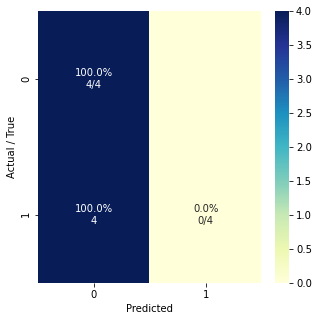

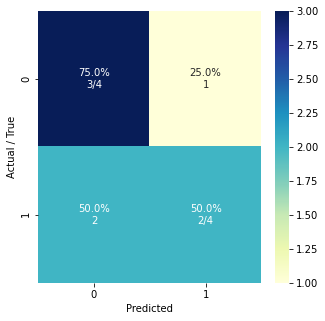

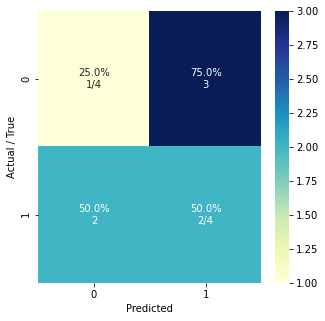

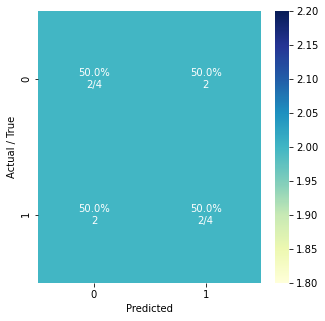

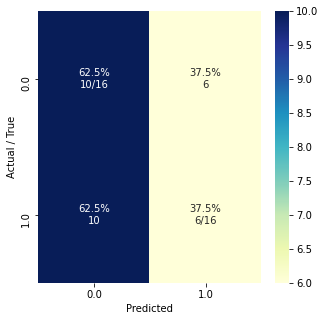

In [237]:
#Couple Hyperparameters
epochs = 20
batch_size_training=128
batch_size_testing=4

# arrays for later work
all_org_class = []
all_pred_class = []
### new end

print("Expected number of Runs = " + str(len(combination_list)))

with mirrored_strategy.scope():

    for training_dir, testing_dir in combination_list:
        print("Starting a run on a new folder setup")
        n_steps_per_epoch = int((len(os.listdir(training_dir + "/covid"))+len(os.listdir(training_dir + "/nocovid" )))/batch_size_training)
        n_validation_steps = int((len(os.listdir(testing_dir + "/covid"))+len(os.listdir(testing_dir + "/nocovid" )))/batch_size_testing)

        training_generator = training_datagen.flow_from_directory(training_dir,
                                                         batch_size=batch_size_training,
                                                         class_mode  = 'binary',
                                                         target_size = (324, 324))

        testing_generator = testing_datagen.flow_from_directory(testing_dir,
                                                    batch_size=batch_size_testing,
                                                    class_mode='binary',
                                                    target_size=(324, 324))
    
    ### new start
    # get the classweights for model.fit class_weight
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(training_generator.labels),
                                                 training_generator.labels)
        class_weights = dict(enumerate(class_weights))
        print(class_weights)
    ### new end

    #training_generator.fit(training_images)
    #testing_generator.fit(testing_images)

        model.compile(optimizer = Adam(learning_rate=lr), 
              loss = 'binary_crossentropy',
              metrics = ['acc'])
    
    
    # fit the model
        history = model.fit_generator(training_generator,
                                  validation_data=testing_generator,
                                  steps_per_epoch=n_steps_per_epoch,
                                  epochs=epochs,
                                  validation_steps=n_validation_steps,
                                  class_weight=class_weights,
                                  verbose=2)
    
    #predicted_class_indices=np.argmax(pred,axis=1)
    

    ### new start
    # set confusionmatrix on each validation runs
    # get original label
        org_class_run = testing_generator.labels
        all_org_class = np.concatenate((all_org_class, org_class_run))

    # reset predict_generator and get prediction
    #predict_generator.reset()
        pred_class_run = model.predict_generator(testing_generator,
                                         verbose=1)

        #pred_class_run = np.argmax(pred_class_run, axis=1)
        #TD: I think, the row below is needed here...
        pred_class_run = np.round(pred_class_run).astype("int").T[0]

        all_pred_class = np.concatenate((all_pred_class, pred_class_run))

    # plot cm on run
        plot_cm(org_class_run, pred_class_run)
    


# plot cm over all runs
plot_cm(all_org_class, all_pred_class)

# Predict on unseen data

In [ ]:
predicting_dir = 'set path here'


prediction_generator = testing_datagen.flow_from_directory(testing_dir,
                                                           #set predicting_dir,
                                                           batch_size=1,
                                                           class_mode='binary',
                                                           target_size=(324, 324))


org_class = prediction_generator.labels

prediction_generator.reset()
pred_class = model.predict_generator(prediction_generator,
                                     verbose=1)

pred_class = np.argmax(pred_class, axis=1)


print('original: ',org_class)
print('predict: ',pred_class)

plot_cm(org_class, pred_class)

# TD: Remaining code obsolete? KFfold testing setup

Load all images in an image and label array with related positioning

can be easy improved with some loops this is just temporary

In [90]:
# Create an array from the dataset


#training_dir         = os.path.join(base_dir, 'training')
#training_covid_dir   = os.path.join(training_dir, 'covid')
#training_nocovid_dir = os.path.join(training_dir, 'nocovid')

#testing_dir          = os.path.join(base_dir, 'testing')
#testing_covid_dir    = os.path.join(testing_dir, 'covid')
#testing_nocovid_dir  = os.path.join(testing_dir, 'nocovid')

target_size_image = 324
images = []
labels = []

for image_name in os.listdir(training_covid_dir):
    img_path_in = os.path.join(training_covid_dir, image_name)
    source_im = Image.open(img_path_in,mode="r")
    source_im_array = np.asarray(source_im)
    source_im_array = cv2.resize(source_im_array, (target_size_image, target_size_image))
    images.append(source_im_array)
    labels.append('1')

for image_name in os.listdir(testing_covid_dir):
    img_path_in = os.path.join(testing_covid_dir, image_name)
    source_im = Image.open(img_path_in,mode="r")
    source_im_array = np.asarray(source_im)
    source_im_array = cv2.resize(source_im_array, (target_size_image, target_size_image))
    images.append(source_im_array)
    labels.append('1')

for image_name in os.listdir(training_nocovid_dir):
    img_path_in = os.path.join(training_nocovid_dir, image_name)
    source_im = Image.open(img_path_in,mode="r")
    source_im_array = np.asarray(source_im)
    source_im_array = cv2.resize(source_im_array, (target_size_image, target_size_image))
    images.append(source_im_array)
    labels.append('0')

for image_name in os.listdir(testing_nocovid_dir):
    img_path_in = os.path.join(testing_nocovid_dir, image_name)
    source_im = Image.open(img_path_in,mode="r")
    source_im_array = np.asarray(source_im)
    source_im_array = cv2.resize(source_im_array, (target_size_image, target_size_image))
    images.append(source_im_array)
    labels.append('0')



labels = np.array(labels).astype('float')
images = np.array(images).astype('float')

In [91]:
#Setting up the generators
#Hyperparameters
batch_size_training = 32
batch_size_testing = 4


training_datagen = ImageDataGenerator(rescale=1.0/255,
                                      rotation_range=10,
                                      zoom_range=0.1,
                                      brightness_range=[0.7,1.3],
                                      horizontal_flip=True,
                                      #vertical_flip=True,  #Not happening in our data
                                      fill_mode='nearest'
                                      )

testing_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [22]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.utils import shuffle


# Amount of KFolders
N_SPLITS = 3

#Hyperparameter
epochs = 1
n_steps_per_epoch = int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training)
n_validation_steps = int((len(os.listdir(testing_covid_dir))+len(os.listdir(testing_nocovid_dir)))/batch_size_testing)

# clear model in memory
#model = None

# set crossvalidation iterator
SKF = StratifiedKFold(n_splits = N_SPLITS, shuffle=True, random_state=12)



for index_fold, (train_index, test_index) in enumerate(SKF.split(images, labels)): #index_fold = global loop counter with end of
    print(train_index)
    print(test_index)
    print('\n--------NEW RUN---------\n')
   
    RUN = "training on fold " + str(index_fold+1) + "-" + str(N_SPLITS)
    print (RUN, '\n')
    #break
    # get the indeces
    
    #print(IMAGES[0].shape)
    
    #X_train, X_test, y_train, y_test = XX[train_index], XX[test_index], yy[train_index], yy[test_index]
    training_images, testing_images, training_labels, testing_labels = images[train_index], images[test_index], labels[train_index], labels[test_index]
    #print('KFold_Train: ', y_train, '\nKFold_Test: ', y_test, '\n')
    
    # reshape, balancing by resampling minority classes reshape, shuffle
    # X_train, y_train = balance2D_minority_class(X_train, y_train)
    # print('Balance_shuffle_train: ', y_train, '\nTest: ', y_test, '\n')

    # break

    # skf.split cant handle 1hot-encoding ... but we need it for cnn
    training_labels = np.array(to_categorical(training_labels), dtype='uint8')
    testing_labels = np.array(to_categorical(testing_labels), dtype='uint8')
    
    #-----------------------------------------------------------------------------------
    
    #look_X_train.append(X_train)
    #look_X_test.append(X_test)
    #look_y_train.append(y_train)
    #look_y_test.append(y_test)
    training_generator = training_datagen.flow(training_images, training_labels, batch_size=batch_size_training)
    testing_generator = testing_datagen.flow(testing_images,testing_labels, batch_size=batch_size_testing)   

    training_generator.fit(training_images)
    testing_generator.fit(testing_images)
    
    # clear model
    # model = None

    # SET THE MODEL HERE in code or pick the define model 
    #model = cnn1(input_shape)

      
    # compile model
    model.compile(optimizer = Adam(learning_rate=lr), 
              loss = 'binary_crossentropy',
              metrics = ['acc'])
    
    
    # fit the model
    history = model.fit_generator(training_generator,
                                  validation_data=testing_generator,
                                  steps_per_epoch=n_steps_per_epoch,
                                  epochs=EPOCHS,
                                  validation_steps=n_validation_steps,
                                  verbose=2)

[   0    2    6 ... 5227 5228 5231]
[   1    3    4 ... 5223 5229 5230]

--------NEW RUN---------

training on fold 1-3 



AttributeError: 'DirectoryIterator' object has no attribute 'fit'

# KFStratified wrap around CNN

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.utils import shuffle


#TEST ARRAYS
XX = [(22,22),(333,333),(55,55),(44,44),(666,666),(88,666),(889,666),(9,666),(9000,666)]
yy = [0,0,0,0,1,1,1,0,2]

XX = np.array(XX)
yy = np.array(yy)




# function confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual / True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)



# function for set up all classes to equal
#def balance2D_minority_class(x_in, y_in):
    #org_shape = x_in.shape
    #vol_shape = x_in.shape[1:]
    #n_voxels = np.prod(vol_shape)
     
    #images_by_voxel = x_in.reshape((x_in.shape[0], n_voxels), order='C')
    
 #   ros = RandomOverSampler(sampling_strategy='not majority', random_state=12, return_indices=True)
  #  x_in, y_in, idx = ros.fit_sample(x_in, y_in)#(images_by_voxel, y_in)
   # print('Oversample indexes:', idx)

  #  x_in, y_in = shuffle(x_in, y_in, random_state=12)
    
    #x_in = x_in.reshape(x_in.shape[0], *vol_shape)
      
  # return x_in, y_in


# things for SKF
N_SPLITS = 3

# things for CNN
EPOCHS = 400
STEP_PER_EPOCH = int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training)
batch_size_training = 32
batch_size_testing = 4

# clear model in memory
model = None

# set crossvalidation iterator
SKF = StratifiedKFold(n_splits = N_SPLITS, shuffle=True, random_state=12)



for index_fold, (train_index, test_index) in enumerate(SKF.split(XX, yy)): #index_fold = global loop counter with end of
    print(train_index)
    print(test_index)
    print('\n--------NEW RUN---------\n')
   
    RUN = "training on fold " + str(index_fold+1) + "-" + str(N_SPLITS)
    print (RUN, '\n')
    #break
    # get the indeces
    
    #print(IMAGES[0].shape)
    
    #X_train, X_test, y_train, y_test = XX[train_index], XX[test_index], yy[train_index], yy[test_index]
    
    print('KFold_Train: ', y_train, '\nKFold_Test: ', y_test, '\n')
    
    # reshape, balancing by resampling minority classes reshape, shuffle
    # X_train, y_train = balance2D_minority_class(X_train, y_train)
    # print('Balance_shuffle_train: ', y_train, '\nTest: ', y_test, '\n')

    # break

    # skf.split cant handle 1hot-encoding ... but we need it for cnn
    y_train = np.array(to_categorical(y_train), dtype='uint8')
    y_test = np.array(to_categorical(y_test), dtype='uint8')
    
    #-----------------------------------------------------------------------------------
    
    look_X_train.append(X_train)
    look_X_test.append(X_test)
    look_y_train.append(y_train)
    #look_y_test.append(y_test)
       
    datagen.fit(X_train)
    
    # clear model
    model = None

    # SET THE MODEL HERE in code or pick the define model 
    #model = cnn1(input_shape)

      
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer = Adam(lr=0.001),
                  metrics=['accuracy'])
    
    
    # fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                  steps_per_epoch=STEP_PER_EPOCH,
                                  epochs=EPOCHS,
                                  verbose=2)
    
    # prediction
    # pred_class = model.predict(X_test)
    # y_predict_class = np.argmax(pred_class, axis=1)
    
    #save predictions on y_test
    #look_y_pred.append(y_predict_class)
    
    # redo 1-hot-encoding
    #y_test_redo_1hot = [np.where(r==1)[0][0] for r in y_test]
    
    # save y_test classes
    #look_y_test.append(y_test_redo_1hot)
    
    # get values outside this loop for global confusion matrix / statistics
    #n_splits_scores.append(accuracy_score(y_test_redo_1hot, y_predict_class))
    #n_splits_y_test = np.concatenate((n_splits_y_test, y_test_redo_1hot))
    #n_splits_y_pred = np.concatenate((n_splits_y_pred, y_predict_class))


    # ready to plot
    #plot_cm(y_true, y_pred)

In [ ]:
## KK imread from 2 class source for KFStratified

CATEGORIES = ["source_covid", "source_nocovid"]

IMG_SIZE = 324




training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(base_dir,category)  # create path to covid noncovid
        class_num = CATEGORIES.index(category)  # get the classification 0 or 1

        for img in tqdm(os.listdir(path)):  # iterate over each image covid noncovid
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:
                pass

create_training_data()
print(len(training_data))

# shuffle the sorted readed images from folder ...00000... , ...11111...
random.shuffle(training_data)

#TD try numpy instead of = []
#IMAGES = np.array() #image
#LABELS = np.array() #label
# split in X and y
#for features,label in training_data:
#    np.append(IMAGES,features)
#    np.append(LABELS,label)

#TD try numpy instead
IMAGES = [] #image
LABELS = [] #label
# split in X and y
for features,label in training_data:
    IMAGES.append(features)
    LABELS.append(label)




# reshape for cnn
IMAGES = np.array(IMAGES).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #1=grayscale
LABELS = np.array(LABELS)

# normalize data between 0 and 1
IMAGES = IMAGES/255.0
np.shape(IMAGES)

In [ ]:
TD1 = np.array([1,2,3,44,5,6,7])
INDEX1 = np.array([3,4,5])
print(TD1[INDEX1])

print(np.append(TD1,3))

# prediction / evaluation (confusion matrix)

In [ ]:
## KK

# get prediction from testing_generator with testdata length
predict = model.predict_generator(testing_generator, steps=len(testing_dir))
#print(predict)

#Y_pred = predict > 0.5
#print(Y_pred)

y_pred = np.argmax(predict, axis=1)
print(y_pred)

# get true class value from testdata
y_true = testing_generator.classes
#print(y_true)


# function confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual / True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# ready to plot
plot_cm(y_true, y_pred)

#confusion_matrix(y_true, y_pred)

# Load image from extern to run trough CNN


In [64]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(324, 324))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Covid_19")
  else:
    print(fn + " NO Covid-19") 

NameError: name 'files' is not defined

# Loading plot library and displaying some images from our dataset

<Figure size 1152x1152 with 0 Axes>

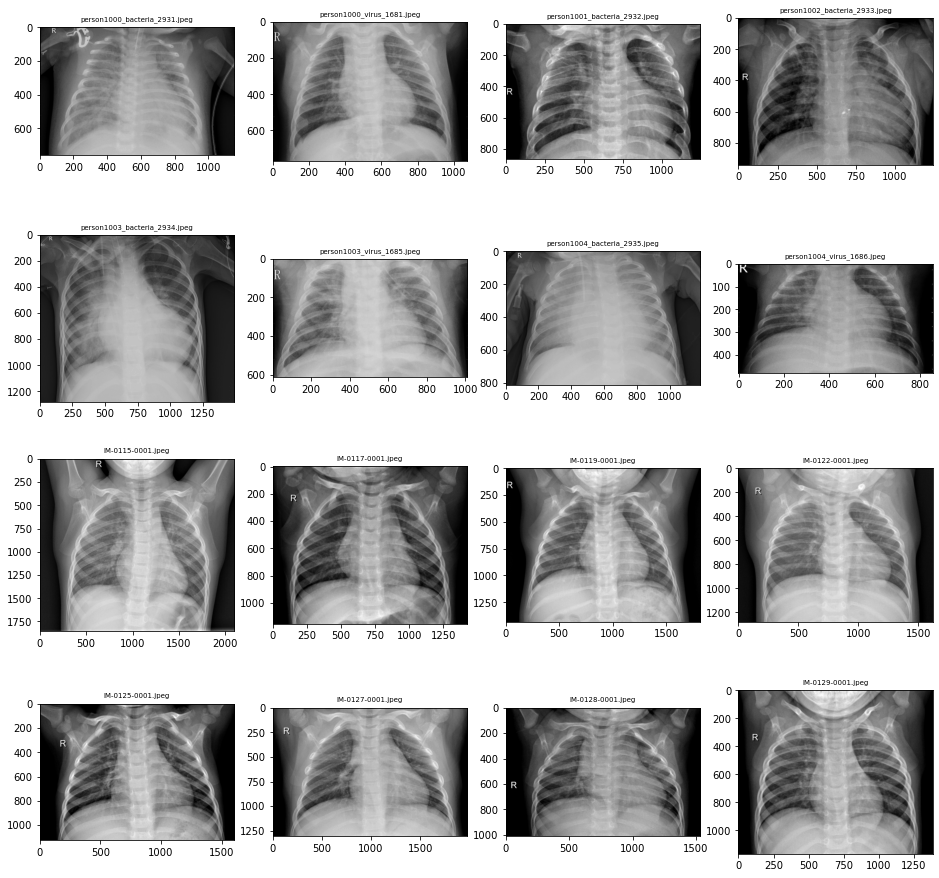

In [22]:
## KK imports nach oben verlagert

#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

# Grid parameters for display
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

#Create a list with the filenames for the iteration
training_covid_names = os.listdir(training_covid_dir)
training_nocovid_names = os.listdir(training_nocovid_dir)


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(training_covid_dir, fname) 
                for fname in training_covid_names[pic_index-8:pic_index]]
next_nocovid_pix = [os.path.join(training_nocovid_dir, fname) 
                for fname in training_nocovid_names[pic_index-8:pic_index]]


#TD now with filenames in the headlines...
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for ax,img_path in zip(axs.flat,next_covid_pix+next_nocovid_pix):
    fname = re.sub('^.*[\/\\\\]','',img_path)
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(fname),fontsize=7)
plt.show()

#Display intermediate steps to see the model working

Random file: ./Xividocx-Data\chest_xray_output\training\covid\person353_virus_728.jpeg


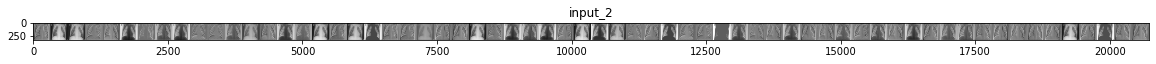

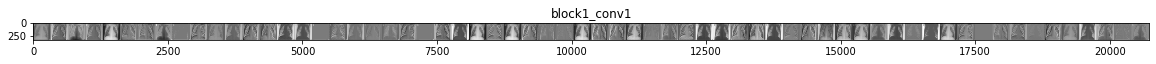

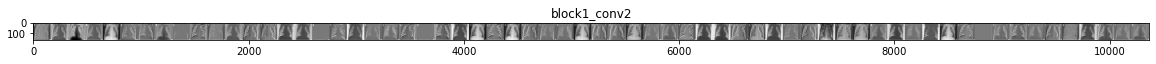

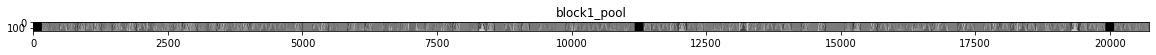

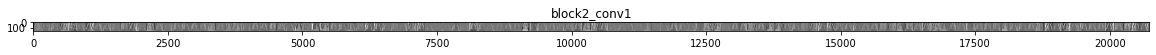

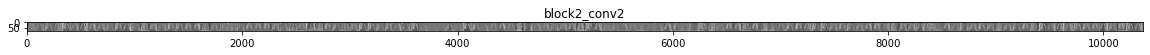

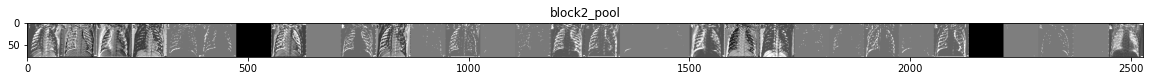

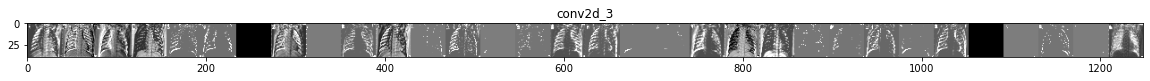

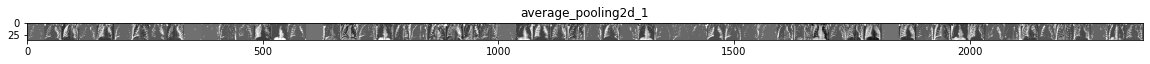

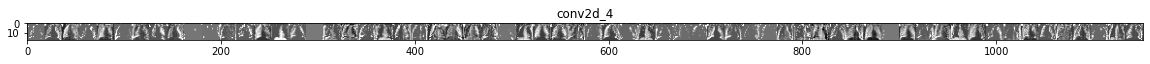

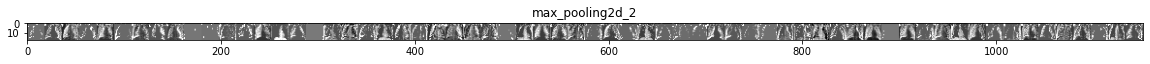

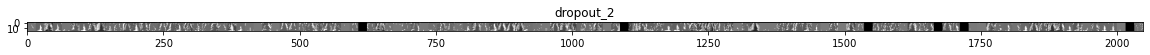

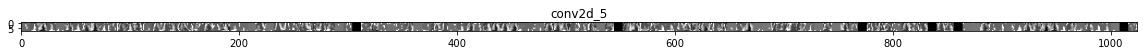

In [24]:
# This will take an image as input, and will output
# intermediate representations for all layers in the given model

training_covid_names = os.listdir(training_covid_dir)
training_nocovid_names = os.listdir(training_nocovid_dir)

successive_outputs = [layer.output for layer in model.layers[1:]]


#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


# Let's prepare a random input image from the training set.
covid_img_files = [os.path.join(training_covid_dir, f) for f in training_covid_names]
nocovid_img_files = [os.path.join(training_nocovid_dir, f) for f in training_nocovid_names]
img_path = random.choice(covid_img_files + nocovid_img_files)
#TD: Which one?
print("Random file: "+img_path)

img = load_img(img_path, target_size=(324, 324))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (324, 324, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 324, 324, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
#TD: Set ",cmap="gray" " here (refer to https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) but also preprocess the incoming data in monochromize()
    plt.imshow(display_grid, aspect='auto', cmap='gray') #cmap='viridis')

# Github repository dataset related cells - not needed for Waterkant

In [0]:
#!pip install -q xlrd
#!git clone https://github.com/ieee8023/covid-chestxray-dataset
#TD Anstelle von dem oberen, dieses hier:
if not os.path.exists("covid-chestxray-dataset"):
    !git clone https://github.com/ieee8023/covid-chestxray-dataset covid-chestxray-dataset
else:
     !git -C covid-chestxray-dataset fetch --all
     !git -C covid-chestxray-dataset reset --hard origin/master

!ls covid-chestxray-dataset/

In [0]:
#TD Do not execute this if you do waterkand20 contest!!!

data_list = pd.read_csv('covid-chestxray-dataset/metadata.csv')

#Copy into source folders
data_dir = 'covid-chestxray-dataset/images'
rows = data_list.patientid 
n = len(rows)
for i in range(1,n):
#TD: Replaced by regex if data_list.loc[i, 'view'] == ('PA' or 'AP'): ... Now also accepting AP Suppinge, for example...
  if re.match(r"^PA|^AP",data_list.loc[i, 'view']):
    if data_list.loc[i, 'finding'] == ('COVID-19'): 
      FROM = os.path.join(data_dir, data_list.loc[i, 'filename'])
      TO = os.path.join(source_covid, data_list.loc[i, 'filename'])
#TD We monochromize the images and also specifically check for "hadcolor" and "nodpi". The files are saved as <name>_monochromized.tif
      copyfileMonochromized(FROM,TO)
#        copyfile(FROM,TO)    if data_list.loc[i, 'finding'] == ('No Finding'):
    if data_list.loc[i, 'finding'] == ('No Finding'):
      FROM = os.path.join(data_dir, data_list.loc[i, 'filename'])
      TO = os.path.join(source_nocovid, data_list.loc[i, 'filename'])
#TD We monochromize the images and also specifically check for "hadcolor" and "nodpi". The files are saved as <name>_monochromized.tif
      copyfileMonochromized(FROM,TO)
#        copyfile(FROM,TO)


In [0]:
#Define a dataset splitting function
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source_list = os.listdir(SOURCE)
    for entry in source_list:
        if (os.path.exists(os.path.join(SOURCE, entry))):
            if (os.path.getsize((os.path.join(SOURCE,entry)) == 0)):
                print('% is zero length, so ignoring' %entry)
                source_list.remove(entry)
                
    source_list = random.sample(source_list, len(source_list))
    
    split_point = int(len(source_list) * SPLIT_SIZE)
    training_list = source_list[:split_point]
    testing_list = source_list[split_point:]

    for entry in training_list:
        FROM = os.path.join(SOURCE, entry)
        TO = os.path.join(TRAINING, entry)
        copyfile(FROM,TO)

    for entry in testing_list:
        FROM = os.path.join(SOURCE, entry)
        TO = os.path.join(TESTING, entry)
        print(FROM+"-->"+TO)
        copyfile(FROM,TO)


#Split the data into the representing sets in a certain ratio
#split_size = .6
#split_data(source_covid, training_covid_dir, testing_covid_dir, split_size)
#split_data(source_nocovid, training_nocovid_dir, testing_nocovid_dir, split_size)  

## KK
#print('training_covid: ', len(training_covid_dir), ' testing_covid: ', len(testing_covid_dir))
#print('training_nocovid: ', len(training_nocovid_dir), ' testing_nocovid: ', len(testing_nocovid_dir))

# Appendix

In [0]:
# Hyperparameters
lr=0.00001 # Learning rate # Adjusted by VD on 3.6.2020
dr=0.4 # Dropout rate
        
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(324, 324, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(dr),  
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dr), \n",
        tf.keras.layers.Dense(1, activation='sigmoid') 
        ])
        
model.compile(optimizer=RMSprop(lr), loss='binary_crossentropy', metrics=['acc'])
      

In [0]:


from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50


def vgg_1(shape_in):
    base_vgg_model = VGG16(include_top = True, input_shape = shape_in, weights ='imagenet')
    
    last_layer = base_vgg_model.layers[-2].output
    
    x = keras.layers.Dropout(0.2, name='dropout_1_0.2')(last_layer)
    x = keras.layers.Dense(1024, activation='relu', name='my_dense_1')(last_layer)
    x = keras.layers.Dropout(0.2, name='dropout_2_0.2')(x)
    x = keras.layers.Dense(256, activation='relu', name='my_dense_2')(x)
    x = keras.layers.Dropout(0.2, name='dropout_3_0.2')(x)
    my_output = keras.layers.Dense(3, activation='softmax', name='my_dense_3')(x)
    
    model = keras.models.Model(inputs=base_vgg_model.inputs, outputs=my_output, name='VGG16_1 ')
    
    for layer in base_vgg_model.layers[:-1]:
        layer.trainable = False
        
    model.summary()
     
    return model

  

def resnet(shape_in):
    base_resnet_model = ResNet50(include_top = True, input_shape = shape_in, weights ='imagenet')

    last_layer = base_resnet_model.layers[-2].output
    
    my_output = keras.layers.Dense(3, activation='softmax', name='my_dense')(last_layer)
    
    model = keras.models.Model(inputs=base_resnet_model.inputs, outputs=my_output, name='ResNet50 ')

    for layer in base_resnet_model.layers[:-1]:
        layer.trainable = False
    
    return model

# Learning Rate Schedulaer e.g. on Stochastic Test run

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))